<a href="https://colab.research.google.com/github/Delicheh/github-slideshow/blob/master/GermanDataset_IndividualConsensusMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual models & Consensus Model Kohonen’s self-organizing maps (SOM)

@misc{riese2019susicode, author = {Riese, Felix~M.}, title = {{SuSi: SUpervised Self-organIzing maps in Python}}, year = {2019}, DOI = {10.5281/zenodo.2609130}, publisher = {Zenodo}, howpublished = {\href{https://doi.org/10.5281/zenodo.2609130}{doi.org/10.5281/zenodo.2609130}} }

In [1]:
pip install susi

  Created wheel for susi: filename=susi-1.0.9-cp36-none-any.whl size=22513 sha256=3665da3d5b94baf0682dff65bf7f5a0f76e13b64497654bbd2d642cb69d39206
  Stored in directory: /root/.cache/pip/wheels/58/36/90/7dee8bfbfd20933bc0e9639ece1d8e5511ac58e08a899e85f2
Successfully built susi


In [2]:
# Import Libraries

from sklearn.preprocessing import normalize, minmax_scale, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.utils import shuffle
import susi
import s3fs
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import the Dataset

germanDataset = pd.read_csv ('s3://dissertationdataset/GermanDataset/GermanDataset.csv')
germanDataset = germanDataset.astype('float64')
print(germanDataset.shape)
print(germanDataset.info())
germanDataset.head()

(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   salary                   1000 non-null   float64
 1   duration                 1000 non-null   float64
 2   creditHistory            1000 non-null   float64
 3   purpose                  1000 non-null   float64
 4   creditAmount             1000 non-null   float64
 5   savingAccount/bonds      1000 non-null   float64
 6   employmentSince          1000 non-null   float64
 7   installmentRate          1000 non-null   float64
 8   personalStatus           1000 non-null   float64
 9   otherDebtors             1000 non-null   float64
 10  presentResidenceSince    1000 non-null   float64
 11  property                 1000 non-null   float64
 12  age                      1000 non-null   float64
 13  otherInstallmentPlan     1000 non-null   float64
 14  housing       

,salary,duration,creditHistory,purpose,creditAmount,savingAccount/bonds,employmentSince,installmentRate,personalStatus,otherDebtors,presentResidenceSince,property,age,otherInstallmentPlan,housing,numberOfExistingCredits,job,maintenance,telephone,foreignWorker,creditStatus
0,1.0,6.0,4.0,3.0,1169.0,5.0,5.0,4.0,3.0,1.0,4.0,1.0,67.0,3.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0
1,2.0,48.0,2.0,3.0,5951.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,22.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0
2,4.0,12.0,4.0,6.0,2096.0,1.0,4.0,2.0,3.0,1.0,3.0,1.0,49.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0
3,1.0,42.0,2.0,2.0,7882.0,1.0,4.0,2.0,3.0,3.0,4.0,2.0,45.0,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0
4,1.0,24.0,3.0,0.0,4870.0,1.0,3.0,3.0,3.0,1.0,4.0,4.0,53.0,3.0,3.0,2.0,3.0,2.0,1.0,1.0,2.0


In [0]:
# Encoding the Credit Status (Replace 2 with 0 (0 Bad , 1 Good))

germanDataset['creditStatus'] = germanDataset['creditStatus'].replace(2, 0)

In [5]:
# Finding features with more than 95% missing 

# Define method for calcuating number of missing values
def missing_values(dataframe):
    missingValuesSum = dataframe.isnull().sum()
    missingValuesPercentage = (missingValuesSum * 100) / dataframe.shape[0]
    missingValuesTable = pd.concat([missingValuesSum, missingValuesPercentage], axis=1)
    missingValuesTable = missingValuesTable.rename(columns = {0 : 'Number of Missing Values', 1 : '% of Total'})
    return missingValuesTable

missing_values(germanDataset)

,Number of Missing Values,% of Total
salary,0,0.0
duration,0,0.0
creditHistory,0,0.0
purpose,0,0.0
creditAmount,0,0.0
savingAccount/bonds,0,0.0
employmentSince,0,0.0
installmentRate,0,0.0
personalStatus,0,0.0
otherDebtors,0,0.0


In [6]:
# Finding number of duplicated rows

duplicate_rows = germanDataset[germanDataset.duplicated()]
duplicate_rows.shape

(0, 21)

In [0]:
# Modify the scale of continuous features

continuousFeatures = ['duration', 'creditAmount', 'age', 'installmentRate', 
                      'presentResidenceSince', 'numberOfExistingCredits']
x = germanDataset[continuousFeatures].values
x_scaled = minmax_scale(x)
dfTemp = pd.DataFrame(x_scaled, columns=continuousFeatures, index = germanDataset.index)
germanDataset[continuousFeatures] = dfTemp

In [8]:
# Dataset description 

Desc_Dataset = germanDataset.describe()

# Standard deviation metrics

Desc_Dataset.loc['+3 std'] = Desc_Dataset.loc['mean'] + (Desc_Dataset.loc['std'] * 3)
Desc_Dataset.loc['-3 std'] = Desc_Dataset.loc['mean'] - (Desc_Dataset.loc['std'] * 3)
Desc_Dataset

,salary,duration,creditHistory,purpose,creditAmount,savingAccount/bonds,employmentSince,installmentRate,personalStatus,otherDebtors,presentResidenceSince,property,age,otherInstallmentPlan,housing,numberOfExistingCredits,job,maintenance,telephone,foreignWorker,creditStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,0.248574,2.545000,2.828000,0.166241,2.105000,3.384000,0.657667,2.68200,1.145000,0.615000,2.358000,0.295464,2.675000,1.929000,0.135667,2.904000,1.155000,1.404000,1.037000,0.700000
std,1.257638,0.177336,1.083120,2.744439,0.155317,1.580023,1.208306,0.372905,0.70808,0.477706,0.367906,1.050209,0.203133,0.705601,0.531264,0.192551,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,0.117647,2.000000,1.000000,0.061379,1.000000,3.000000,0.333333,2.00000,1.000000,0.333333,1.000000,0.142857,3.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000
50%,2.000000,0.205882,2.000000,2.000000,0.113871,1.000000,3.000000,0.666667,3.00000,1.000000,0.666667,2.000000,0.250000,3.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000
75%,4.000000,0.294118,4.000000,3.000000,0.204812,3.000000,5.000000,1.000000,3.00000,1.000000,1.000000,3.000000,0.410714,3.000000,2.000000,0.333333,3.000000,1.000000,2.000000,1.000000,1.000000
max,4.000000,1.000000,4.000000,10.000000,1.000000,5.000000,5.000000,1.000000,4.00000,3.000000,1.000000,4.000000,1.000000,3.000000,3.000000,1.000000,4.000000,2.000000,2.000000,2.000000,1.000000
+3 std,6.349913,0.780580,5.794359,11.061318,0.632193,6.845068,7.008919,1.776381,4.80624,2.578119,1.718718,5.508627,0.904864,4.791803,3.522791,0.713321,4.864842,2.241257,2.876829,1.603569,2.075461
-3 std,-1.195913,-0.283433,-0.704359,-5.405318,-0.299711,-2.635068,-0.240919,-0.461048,0.55776,-0.288119,-0.488718,-0.792627,-0.313936,0.558197,0.335209,-0.441988,0.943158,0.068743,-0.068829,0.470431,-0.675461


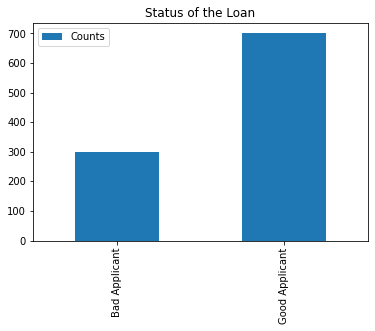

In [9]:
# Visualise (Target variable) Credit Status 

bad = germanDataset[germanDataset['creditStatus'] == 0]['creditStatus'].count()
good = germanDataset[germanDataset['creditStatus'] == 1]['creditStatus'].count()
data = {"Counts":[bad, good] }
applicantStatus = pd.DataFrame(data, index=["Bad Applicant", "Good Applicant"])
applicantStatus.plot(kind='bar', title="Status of the Loan")

In [0]:
# Shuffle rows of the dataframe

germanDataset = shuffle(germanDataset, random_state=42)
germanDataset.reset_index (drop=True , inplace=True)

In [11]:
# Split data into traning 70%  & test 30%

dataset, testDataset = np.split(germanDataset, [int(.7 * len(germanDataset))])
print(dataset.shape)
print(testDataset.shape)

(700, 21)
(300, 21)


In [12]:
# Number of high correlated features (correlation greater than 0.7)

correlation = dataset.corr().abs()
high = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
highList = [column for column in high.columns if any(high[column] > 0.7)]
print("Number of feature columns with correlation greater than 0.7 :", len(highList))

Number of feature columns with correlation greater than 0.7 : 0


In [13]:
# Features List

featureList = dataset.columns[:-1]
featureList

Index(['salary', 'duration', 'creditHistory', 'purpose', 'creditAmount',
       'savingAccount/bonds', 'employmentSince', 'installmentRate',
       'personalStatus', 'otherDebtors', 'presentResidenceSince', 'property',
       'age', 'otherInstallmentPlan', 'housing', 'numberOfExistingCredits',
       'job', 'maintenance ', 'telephone', 'foreignWorker'],
      dtype='object')

In [0]:
#  Define Label and Features

X = dataset.drop ('creditStatus' , axis=1)
y = dataset['creditStatus']

In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "min_samples_leaf": np.arange(3, 10)}

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}

In [16]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Print the name and gini importance of each feature
for feature in zip(featureList , clf.feature_importances_):
    print(feature)

('salary', 0.15854189042471362)
('duration', 0.10631961748613251)
('creditHistory', 0.05912139900331556)
('purpose', 0.0538410304399028)
('creditAmount', 0.13543089003608777)
('savingAccount/bonds', 0.0520422757429839)
('employmentSince', 0.04776494168934713)
('installmentRate', 0.04111330501804116)
('personalStatus', 0.03744396877050522)
('otherDebtors', 0.012813887899022613)
('presentResidenceSince', 0.04242635531050019)
('property', 0.038047713091531016)
('age', 0.0958528066742112)
('otherInstallmentPlan', 0.03109351428304357)
('housing', 0.022545303028238733)
('numberOfExistingCredits', 0.014466624960644572)
('job', 0.023631111182157095)
('maintenance ', 0.01045795692232315)
('telephone', 0.015033756053221442)
('foreignWorker', 0.002011651984076874)


## 1 - Logistic Regression

In [17]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmLR = SelectFromModel(clf, threshold = 0.035)

# Train the selector
sfmLR.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmLR.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmLR.transform(X)
XX_important = sfmLR.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  12


Accuracy of Test set :  0.7966666666666666
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7799999999999999
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[190  18]
 [ 43  49]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.53      0.62        92
         1.0       0.82      0.91      0.86       208

    accuracy                           0.80       300
   macro avg       0.77      0.72      0.74       300
weighted avg       0.79      0.80      0.79       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.815451  0.268657
Bad (0)   0.184549  0.731343
-------------------------------------------------------------------------------------

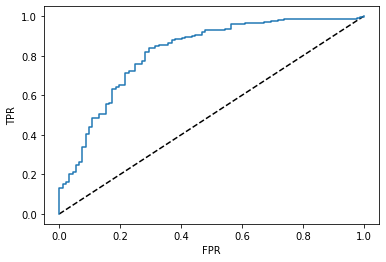

AUC of Test set :  0.8155831939799331
MCC of Test set :  0.49387092968603324


In [18]:
# Create a new Logistic Regression classifier for the selected features
LR_clf_important = LogisticRegression(random_state=42)

# Train the new classifier on the new dataset containing the selected features
LR_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = LR_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(LR_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = LR_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
LRTest = LR_clf_important.predict(XX_important)
LR = LR_clf_important.predict(X_important_train)

## 2 - ANN

In [20]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmANN = SelectFromModel(clf, threshold = 0.03)

# Train the selector
sfmANN.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmANN.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmANN.transform(X)
XX_important = sfmANN.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
otherInstallmentPlan
----------------------------------------------------------------------------------------------------
Number of selected featurs:  13


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'hidden_layer_sizes': np.arange(10,50) , "alpha": [0.001, 0.01, 0.1, 1]}

# clf = MLPClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'alpha': 0.001, 'hidden_layer_sizes': 38}

Accuracy of Test set :  0.7966666666666666
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7933333333333333
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[190  18]
 [ 43  49]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.53      0.62        92
         1.0       0.82      0.91      0.86       208

    accuracy                           0.80       300
   macro avg       0.77      0.72      0.74       300
weighted avg       0.79      0.80      0.79       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.815451  0.268657
Bad (0)   0.184549  0.731343
-------------------------------------------------------------------------------------

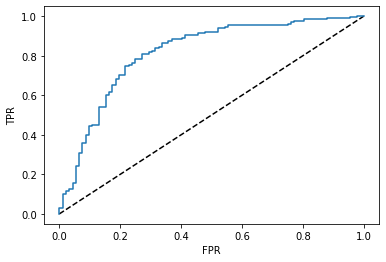

AUC of Test set :  0.8153219063545151
MCC of Test set :  0.49387092968603324


In [22]:
# Create a new MLP classifier for the selected features
ANN_clf_important = MLPClassifier(alpha = 0.001, hidden_layer_sizes = (38) ,random_state = 42)

# Train the new classifier on the new dataset containing the selected features
ANN_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = ANN_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(ANN_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = ANN_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
ANNTest = ANN_clf_important.predict(XX_important)
ANN = ANN_clf_important.predict(X_important_train)

## 3 - Decision Trees

In [24]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmDT = SelectFromModel(clf, threshold = 0.035)

# Train the selector
sfmDT.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmDT.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmDT.transform(X)
XX_important = sfmDT.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  12


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'min_samples_split': np.arange (5, 20), 'max_depth': np.arange(5, 15)}

# clf = DecisionTreeClassifier(random_state = 42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 6, 'min_samples_split': 8}

Accuracy of Test set :  0.73
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.6599999999999999
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[177  31]
 [ 50  42]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.46      0.51        92
         1.0       0.78      0.85      0.81       208

    accuracy                           0.73       300
   macro avg       0.68      0.65      0.66       300
weighted avg       0.72      0.73      0.72       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.779736  0.424658
Bad (0)   0.220264  0.575342
---------------------------------------------------------------------------------------------------

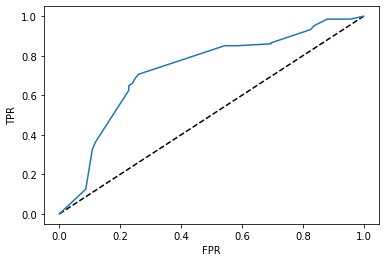

AUC of Test set :  0.7278428093645485
MCC of Test set :  0.3304248672912749


In [26]:
# Create a new decision tree classifier for the selected features
DT_clf_important = DecisionTreeClassifier(min_samples_split = 8, random_state = 42, max_depth = 6)

# Train the new classifier on the new dataset containing the selected features
DT_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = DT_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(DT_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = DT_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
DTTest = DT_clf_important.predict(XX_important)
DT = DT_clf_important.predict(X_important_train)

## 4 - Gradient Boosting Decision Trees 

In [28]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmGBDT = SelectFromModel(clf, threshold = 0.01)

# Train the selector
sfmGBDT.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmGBDT.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmGBDT.transform(X)
XX_important = sfmGBDT.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
otherDebtors
presentResidenceSince
property
age
otherInstallmentPlan
housing
numberOfExistingCredits
job
maintenance 
telephone
----------------------------------------------------------------------------------------------------
Number of selected featurs:  19


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "learning_rate": [0.001, 0.01, 0.1, 1]}

# clf = GradientBoostingClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

Accuracy of Test set :  0.77
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7633333333333334
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[177  31]
 [ 38  54]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.61        92
         1.0       0.82      0.85      0.84       208

    accuracy                           0.77       300
   macro avg       0.73      0.72      0.72       300
weighted avg       0.77      0.77      0.77       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.823256  0.364706
Bad (0)   0.176744  0.635294
---------------------------------------------------------------------------------------------------

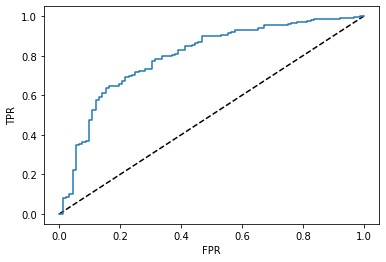

AUC of Test set :  0.7974498327759199
MCC of Test set :  0.4481152715001588


In [30]:
# Create a new GBDT classifier for the selected features
GBDT_clf_important = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=300, random_state=42)

# Train the new classifier on the new dataset containing the selected features
GBDT_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = GBDT_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(GBDT_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = GBDT_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
GBDTTest = GBDT_clf_important.predict(XX_important)
GBDT = GBDT_clf_important.predict(X_important_train)

## 5 - kNN

In [32]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmKNN = SelectFromModel(clf, threshold = 0.01)

# Train the selector
sfmKNN.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmKNN.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmKNN.transform(X)
XX_important = sfmKNN.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
otherDebtors
presentResidenceSince
property
age
otherInstallmentPlan
housing
numberOfExistingCredits
job
maintenance 
telephone
----------------------------------------------------------------------------------------------------
Number of selected featurs:  19


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'n_neighbors': np.arange(3, 10)}

# clf = KNeighborsClassifier()
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'n_neighbors': 9}

Accuracy of Test set :  0.7566666666666667
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.75
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[191  17]
 [ 56  36]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.39      0.50        92
         1.0       0.77      0.92      0.84       208

    accuracy                           0.76       300
   macro avg       0.73      0.65      0.67       300
weighted avg       0.74      0.76      0.73       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.773279  0.320755
Bad (0)   0.226721  0.679245
---------------------------------------------------------------------------------------------------

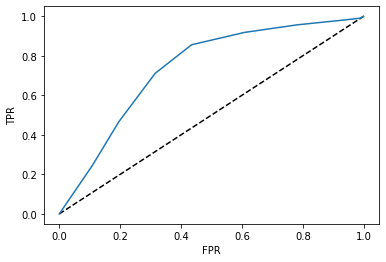

AUC of Test set :  0.7374843227424748
MCC of Test set :  0.3742855470566793


In [34]:
# Create a new kNN classifier for the selected features
KNN_clf_important = KNeighborsClassifier(n_neighbors=9)

# Train the new classifier on the new dataset containing the selected features
KNN_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = KNN_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(KNN_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = KNN_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
KNNTest = KNN_clf_important.predict(XX_important)
KNN = KNN_clf_important.predict(X_important_train)

## 6 - Random Forest

In [36]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.015 (SVM)
sfmRF = SelectFromModel(clf, threshold = 0.02)

# Train the selector
sfmRF.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmRF.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmRF.transform(X)
XX_important = sfmRF.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
otherInstallmentPlan
housing
job
----------------------------------------------------------------------------------------------------
Number of selected featurs:  15


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "min_samples_leaf": np.arange(3, 10)}

# clf = RandomForestClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 12, 'min_samples_leaf': 4, 'n_estimators': 200}

Accuracy of Test set :  0.7933333333333333
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7866666666666667
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[196  12]
 [ 50  42]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.46      0.58        92
         1.0       0.80      0.94      0.86       208

    accuracy                           0.79       300
   macro avg       0.79      0.70      0.72       300
weighted avg       0.79      0.79      0.78       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.796748  0.222222
Bad (0)   0.203252  0.777778
-------------------------------------------------------------------------------------

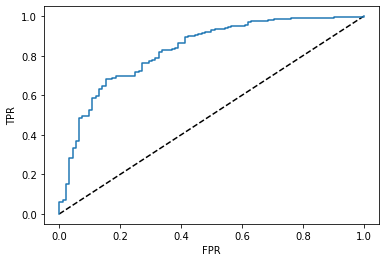

AUC of Test set :  0.8284908026755853
MCC of Test set :  0.4786833779520614


In [38]:
# Create a new random forest classifier for the selected features
RF_clf_important = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=12, min_samples_leaf=4, n_jobs=-1)

# Train the new classifier on the new dataset containing the selected features
RF_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = RF_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(RF_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = RF_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
RFTest = RF_clf_important.predict(XX_important)
RF = RF_clf_important.predict(X_important_train)

## 7 - SVM

In [40]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than 
# 0.035 (LR), 0.03 (ANN), 0.035 (DT), 0.01 (GBDT), 0.01 (kNN), 0.02 (RF) , 0.01 (SVM)
sfmSVM = SelectFromModel(clf, threshold = 0.01)

# Train the selector
sfmSVM.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmSVM.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmSVM.transform(X)
XX_important = sfmSVM.transform(XX)

salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
otherDebtors
presentResidenceSince
property
age
otherInstallmentPlan
housing
numberOfExistingCredits
job
maintenance 
telephone
----------------------------------------------------------------------------------------------------
Number of selected featurs:  19


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'C' : [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1, 10]}

# clf = svm.SVC(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'C': 1, 'gamma': 0.1}

Accuracy of Test set :  0.7666666666666667
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7933333333333333
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[192  16]
 [ 54  38]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.41      0.52        92
         1.0       0.78      0.92      0.85       208

    accuracy                           0.77       300
   macro avg       0.74      0.67      0.68       300
weighted avg       0.76      0.77      0.75       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.780488  0.296296
Bad (0)   0.219512  0.703704
-------------------------------------------------------------------------------------

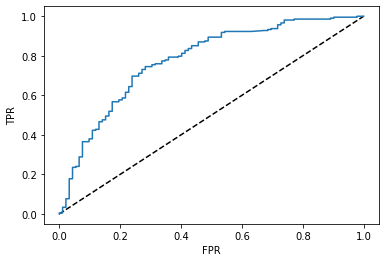

AUC of Test set :  0.778689381270903
MCC of Test set :  0.4034186958841272


In [42]:
# Create a new SVM classifier for the selected features
SVM_clf_important = svm.SVC(probability=True, C = 1, gamma= 0.1, kernel='rbf', random_state=42)

# Train the new classifier on the new dataset containing the selected features
SVM_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = SVM_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(SVM_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = SVM_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
SVMTest = SVM_clf_important.predict(XX_important)
SVM = SVM_clf_important.predict(X_important_train)

## Consensus Model Kohonen’s self-organizing maps (SOM)

In [0]:
# Individual models outcomes (Create training dataset based on result of models)

somDataset = pd.DataFrame ({"LR": LR, "ANN": ANN, "DT": DT, "GBDT": GBDT, "KNN": KNN, "RF": RF, "SVM":SVM})

In [0]:
# Individual models outcomes (Create Test dataset based on result of models)

somTestDataset = pd.DataFrame ({"LR": LRTest, "ANN": ANNTest, "DT": DTTest, "GBDT": GBDTTest,
                                "KNN": KNNTest, "RF": RFTest, "SVM":SVMTest})

In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"n_iter_supervised" : [1000, 50000], 
#          "n_iter_unsupervised" : [1000, 50000],
#          "do_class_weighting" : [False, True]}

# clf = susi.SOMClassifier(random_state=42, n_jobs=-1)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(somDataset, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'do_class_weighting': False, 'n_iter_supervised': 50000, 'n_iter_unsupervised': 50000}

@misc{riese2019susicode, author = {Riese, Felix~M.}, title = {{SuSi: SUpervised Self-organIzing maps in Python}}, year = {2019}, DOI = {10.5281/zenodo.2609130}, publisher = {Zenodo}, howpublished = {\href{https://doi.org/10.5281/zenodo.2609130}{doi.org/10.5281/zenodo.2609130}} }

In [47]:
# Create a new SOM classifier for the selected features
som = susi.SOMClassifier(n_jobs=-1, random_state=42, do_class_weighting=False,
                         n_iter_supervised=50000, n_iter_unsupervised=50000)
# Train the new classifier on the new dataset containing the selected features
som.fit(somDataset, y)

SOMClassifier(distance_metric='euclidean', do_class_weighting=False,
              init_mode_supervised='majority', init_mode_unsupervised='random',
              learn_mode_supervised='min', learn_mode_unsupervised='min',
              learning_rate_end=0.05, learning_rate_start=0.5,
              missing_label_placeholder=None, n_columns=10,
              n_iter_supervised=50000, n_iter_unsupervised=50000, n_jobs=-1,
              n_rows=10, nbh_dist_weight_mode='pseudo-gaussian',
              neighborhood_mode_supervised='linear',
              neighborhood_mode_unsupervised='linear', random_state=42,
              train_mode_supervised='online', train_mode_unsupervised='online',
              verbose=0)

In [48]:
# Train set 
y_train_pred = som.predict(somDataset)

print("Accuracy of Train set : ", accuracy_score(y, y_train_pred))
print('-'*100)

Accuracy of Train set :  0.9814285714285714
----------------------------------------------------------------------------------------------------


In [49]:
# Apply The Full Featured Classifier To The Test Data
yy_pred = som.predict(somTestDataset)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
          
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

Accuracy of Test set :  0.8
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[176  32]
 [ 28  64]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68        92
         1.0       0.86      0.85      0.85       208

    accuracy                           0.80       300
   macro avg       0.76      0.77      0.77       300
weighted avg       0.80      0.80      0.80       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.862745  0.333333
Bad (0)   0.137255  0.666667
----------------------------------------------------------------------------------------------------
MCC of Test set :  0.5355730400345808


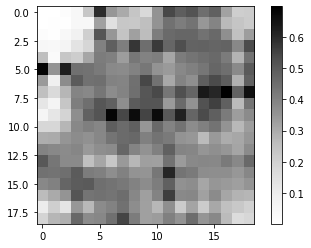

In [50]:
# Plot u-Matrix 

u_matrix = som.get_u_matrix()
plt.imshow(np.squeeze(u_matrix), cmap="Greys")
plt.colorbar()
plt.show()

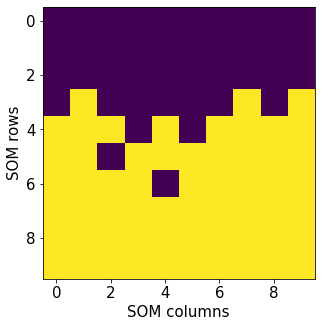

In [51]:
# Plot estimation map

def plot_estimation_map(estimation_map, fontsize=15):
    plt.figure(figsize=(7,5))
    plt.imshow(estimation_map, cmap="viridis_r")
    plt.xlabel("SOM columns", fontsize=fontsize)
    plt.ylabel("SOM rows", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(b=False)

estimation_map = som.get_estimation_map().squeeze()
plot_estimation_map(estimation_map)